In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msn

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler


In [2]:
original_dataset = pd.read_csv("./data/NigeriaInflationRates03-24.csv")
exchange_rates = pd.read_csv("./data/exchange09082024.csv")

In [3]:
original_dataset.tail()

,Year,Month,Inflation_Rate,Crude Oil Price,Production,Crude Oil Export,CPI_Food,CPI_Energy,CPI_Health,CPI_Transport,CPI_Communication,CPI_Education
193,2024,2,31.70,86.08,1.32,0.87,846.846533,543.893969,494.844568,570.034088,234.228948,469.899712
194,2024,3,33.20,88.80,1.23,0.78,877.472863,558.813016,502.912687,579.821453,234.694654,476.890292
195,2024,4,33.69,93.12,1.28,0.83,899.453386,571.960431,510.095879,592.282753,235.335975,483.719840
196,2024,5,33.95,84.01,1.25,0.80,920.005281,583.894158,517.391784,606.408076,235.850405,490.779792
197,2024,6,34.19,83.64,1.28,0.83,943.458769,596.496022,524.747711,620.966251,236.061986,498.242239


### Exchange rate
Nigeria is an import dependent country, thus, the exchange rate significantly affects the inflation rate 

In [4]:
# Selecting exchange rates for the US Dollar only
exchange_rates.head()
exchange_rates.query("Currency == 'US DOLLAR'", inplace=True)
exchange_rates.drop(columns=["Currency", "Rate Date"], inplace=True)
exchange_rates.reset_index(drop=True, inplace=True)

In [5]:
# Preprosessing an dtokenization of data
# Taking the monthly average of the dollar exchange rate 

def correct(x):
    if x == "August\t":
        return "August"
    return x

months = {
    "January": 1,
    "February": 2,
    "March": 3, 
    "April": 4, 
    "May": 5, 
    "June": 6, 
    "July": 7, 
    "August": 8, 
    "'August\t": 8,
    "September": 9,
    "October": 10, 
    "November": 11, 
    "December": 12
}

exchange_rates["Rate Month"] = exchange_rates["Rate Month"].apply(correct)

# convert months to numerical representation
exchange_rates["Rate Month"] = exchange_rates["Rate Month"].apply(lambda x: months[x])



In [6]:
per = pd.DataFrame(exchange_rates["Rate Month"].rename("Month", inplace=True), exchange_rates["Rate Year"].rename("Year", inplace=True)).reset_index()

In [7]:
exchange_rates["Date"] = pd.to_datetime(per.assign(Day = 1))

In [8]:
exchange_rates

,Rate Year,Rate Month,Buying Rate,Central Rate,Selling Rate,Date
0,2024,8,1583.027,1583.527,1584.027,2024-04-01
1,2024,8,1591.080,1591.580,1592.080,2024-04-01
2,2023,8,1592.136,1592.636,1593.136,2023-04-01
3,2024,8,1605.520,1606.020,1606.520,2024-04-01
4,2024,8,1618.232,1618.732,1619.232,2024-04-01
...,...,...,...,...,...,...
5536,2001,12,112.100,112.600,113.100,2001-05-01
5537,2001,12,111.850,112.350,112.850,2001-05-01
5538,2001,12,111.850,112.350,112.850,2001-05-01
5539,2001,12,111.850,112.350,112.850,2001-05-01


In [9]:
#determining the monthly average exchange rate 
grouped_year = exchange_rates.groupby(by="Rate Year")
exchange_monthly = {
    "year": [],
    "month": [],
    "Buying_rate": [],
    "Selling_rate": []
}
for year in grouped_year.groups:
    grouped_month = grouped_year.get_group(year).groupby("Rate Month")
    for month in grouped_month.groups:
        buying, selling = grouped_month.get_group(month)[["Buying Rate", "Selling Rate"]].mean()

        exchange_monthly["year"].append(year)
        exchange_monthly["month"].append(month)
        exchange_monthly["Buying_rate"].append(buying)
        exchange_monthly["Selling_rate"].append(selling)
exchange_monthly = pd.DataFrame(exchange_monthly)
exchange_monthly["Date"] = pd.to_datetime(exchange_monthly[["year", "month"]].assign(Day=1))
exchange_monthly.set_index("Date", inplace=True)
exchange_monthly.drop(columns=["year", "month"], inplace=True)
exchange_monthly.sort_index(inplace=True)
exchange_monthly.head()

,Buying_rate,Selling_rate
Date,,
2001-12-01,112.115385,113.115385
2002-01-01,112.915909,113.915909
2002-02-01,113.752632,114.752632
2002-03-01,115.060000,116.060000
2002-04-01,115.128571,116.128571


In [10]:
original_dataset["Date"] = pd.to_datetime(original_dataset[["Year", "Month"]].assign(Day=1))
original_dataset.set_index("Date", inplace=True)
original_dataset.drop(columns=["Year", "Month"], inplace=True)
original_dataset.sort_index(inplace=True)
original_dataset.head()

,Inflation_Rate,Crude Oil Price,Production,Crude Oil Export,CPI_Food,CPI_Energy,CPI_Health,CPI_Transport,CPI_Communication,CPI_Education
Date,,,,,,,,,,
2008-01-01,8.6,94.26,2.17,1.72,75.534431,84.612846,83.863139,86.530038,83.129440,75.284466
2008-02-01,8.0,98.15,2.08,1.63,75.154185,85.231632,83.365891,88.355236,82.889814,75.457619
2008-03-01,7.8,103.73,2.06,1.61,78.242523,83.251516,86.082993,84.376304,81.893471,74.826847
2008-04-01,8.2,116.73,1.96,1.51,79.434268,84.348830,89.445332,88.600334,93.937865,73.664248
2008-05-01,9.7,126.57,2.05,1.60,80.783677,85.574027,90.540461,87.932833,97.553285,74.880442


In [11]:
# Including Dollar exchange rate to dataset 
select = []

for date in exchange_monthly.index:
    if date in original_dataset.index:
        select.append(True)
    else:
        select.append(False)

len(select)

inflation = pd.concat([original_dataset, exchange_monthly.loc[select]], axis=1)

inflation.drop(columns=["Crude Oil Price"], inplace=True)
inflation.ffill(axis= 0, inplace=True)
inflation.head()

,Inflation_Rate,Production,Crude Oil Export,CPI_Food,CPI_Energy,CPI_Health,CPI_Transport,CPI_Communication,CPI_Education,Buying_rate,Selling_rate
Date,,,,,,,,,,,
2008-01-01,8.6,2.17,1.72,75.534431,84.612846,83.863139,86.530038,83.129440,75.284466,115.807727,116.807727
2008-02-01,8.0,2.08,1.63,75.154185,85.231632,83.365891,88.355236,82.889814,75.457619,115.791429,116.791429
2008-03-01,7.8,2.06,1.61,78.242523,83.251516,86.082993,84.376304,81.893471,74.826847,115.752778,116.752778
2008-04-01,8.2,1.96,1.51,79.434268,84.348830,89.445332,88.600334,93.937865,73.664248,115.708182,116.708182
2008-05-01,9.7,2.05,1.60,80.783677,85.574027,90.540461,87.932833,97.553285,74.880442,115.669000,116.669000


<Axes: >

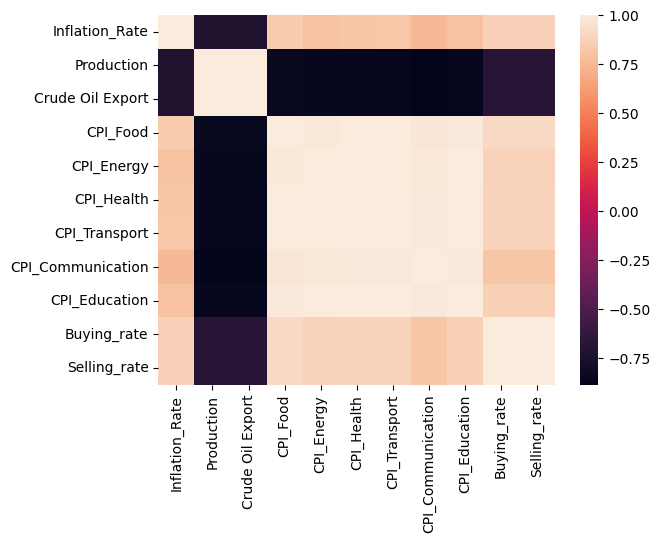

In [12]:
# Correlation matrix of inflation data
sns.heatmap(inflation.corr())

In [13]:
# Correlation indexes between features and Inflation rate

inflation.corr()["Inflation_Rate"]


Inflation_Rate       1.000000
Production          -0.718979
Crude Oil Export    -0.718979
CPI_Food             0.841377
CPI_Energy           0.795769
CPI_Health           0.815598
CPI_Transport        0.817517
CPI_Communication    0.756104
CPI_Education        0.798156
Buying_rate          0.869172
Selling_rate         0.869222
Name: Inflation_Rate, dtype: float64

### Calculating moving average 
Taking moving to smoothen the noise

<Axes: >

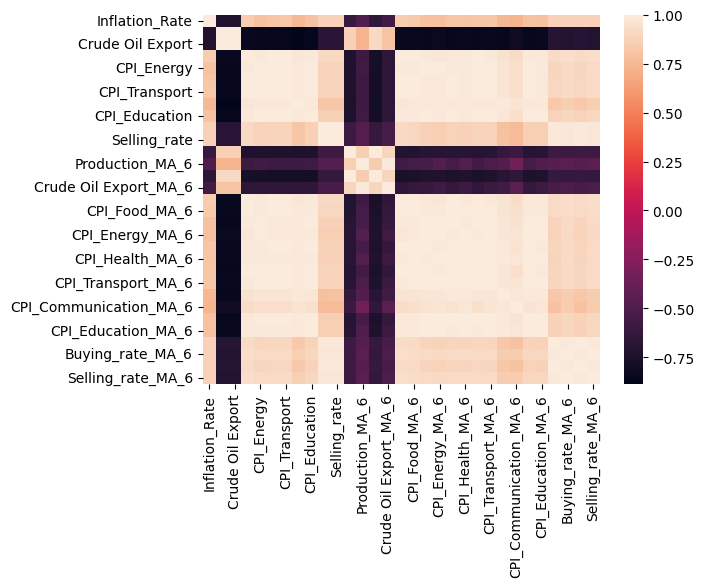

In [14]:
# Moving average is a noise smoothening technique, it allows trend formation 
# Allowing the model to capture trends 

short_term = 3 # Months
medium_term = 6 # Months
# long_term = 9 # Months

features = inflation.keys()[1:]

for feature in features:
    inflation[f"{feature}_MA_{short_term}"] = inflation[feature].rolling(short_term).mean()
    inflation[f"{feature}_MA_{medium_term}"] = inflation[feature].rolling(medium_term).mean()
    #inflation[f"{feature}_MA_{long_term}"] = inflation[feature].rolling(long_term).mean()

inflation.fillna(0, inplace=True)
sns.heatmap(inflation.corr())

In [26]:
# Feature selection 
threshold = 0.81 # selecting futures that are above threshold 
correlation_matrix = inflation.corr()["Inflation_Rate"]
features = correlation_matrix[abs(correlation_matrix) >= threshold].iloc[1:].keys()

features

Index(['CPI_Food', 'CPI_Health', 'CPI_Transport', 'Buying_rate',
       'Selling_rate', 'CPI_Food_MA_3', 'CPI_Food_MA_6', 'CPI_Health_MA_3',
       'CPI_Transport_MA_3', 'Buying_rate_MA_3', 'Buying_rate_MA_6',
       'Selling_rate_MA_3', 'Selling_rate_MA_6'],
      dtype='object')

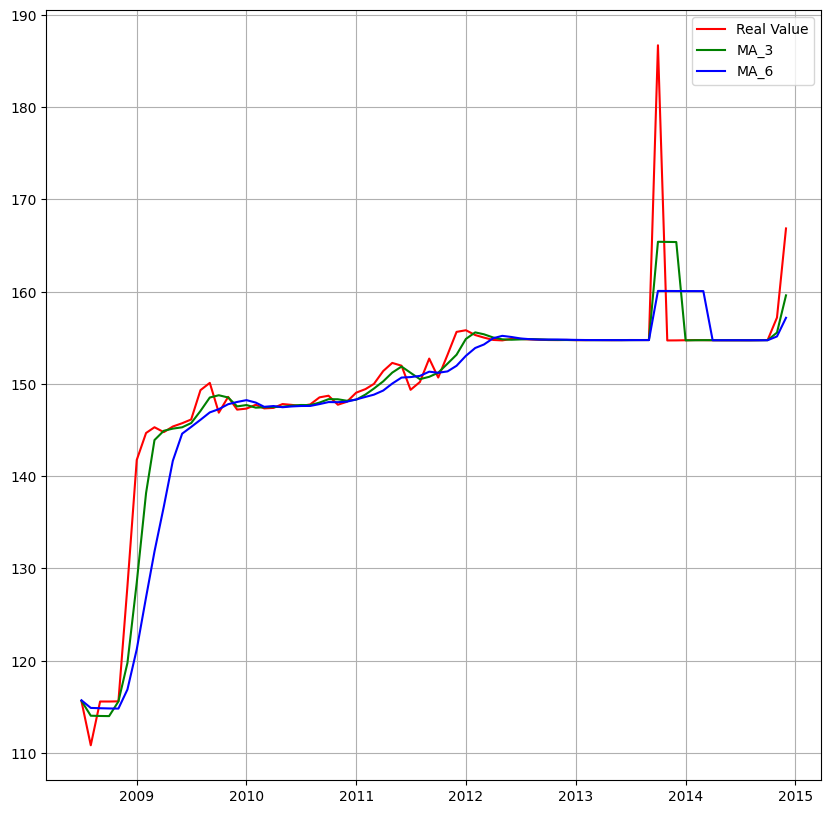

In [35]:
plt.figure(figsize=(10, 10))
plt.plot(inflation.index[6:84], inflation["Buying_rate"].iloc[6:84], c="r", label="Real Value")
plt.plot(inflation.index[6:84], inflation["Buying_rate_MA_3"].iloc[6:84], c="g", label="MA_3")
plt.plot(inflation.index[6:84], inflation["Buying_rate_MA_6"].iloc[6:84], c="b" ,label="MA_6")

plt.legend()
plt.grid()

<div>
    <p>From the chart above, we can observe that the live dollar rate is volatile, distorting the overall trend. However, volatility is reduced in 
    the moving averages allowing for trend formation</p>
</div>

### Normalization of dataset

In [37]:
X = inflation[features]
Y = inflation["Inflation_Rate"]

# A holdout set is used simply for showing the models performance during testing, but this is not neccesarry because of model will be trained 
# and tested using a time series split combined with cross validation. 

# X, withheld_x, Y, withheld_y = train_test_split(X, Y, test_size=0.05, random_state=2024)
# Y.sort_index(inplace=True)
# withheld_y.sort_index(inplace=True)
# X.sort_index(inplace=True)
# withheld_x.sort_index(inplace=True)

# Not applying any form of standardization gives better results
# scaler = StandardScaler()
# X, withheld_x = scaler.fit_transform(X), scaler.transform(withheld_x)


### Machine learning approach

Since the dataset is a timeseries, using a time series split would prevent the model from learning from future data set, ensuring 
it captures past trend. 

After training and evaluating these base models, the best would be selected and a grid search would be performed to determine best parameters for 
this model

In [39]:
# finding an optimal model
models = {
    "linear_regression": LinearRegression(),
    "lasso": Lasso(),
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(), 
    "XGboost_reg": GradientBoostingRegressor()
}

result = []

# Using the time series split to get train and test sets for base models 
for mod in models:
    time_split = TimeSeriesSplit(n_splits=7).split(X, Y)
    mse, mae, r2 = [], [], [] # average performance for n splits
    for train_index, test_index in time_split:
        x_train, x_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
        # x_train, x_test, y_train, y_test = X[train_index], X[test_index], Y.iloc[train_index], Y.iloc[test_index]
        test_model = models[mod].fit(x_train, y_train)
        prediction = test_model.predict(x_test)

        mse.append(mean_absolute_error(y_test, prediction))
        mae.append(mean_squared_error(y_test, prediction))
        r2.append(r2_score(y_test, prediction))

    result.append({"Model": mod, 
                "MSE": np.mean(mse), 
                "MAE": np.mean(mae), 
                "R-2": np.mean(r2)
    })
    

pd.DataFrame(result)

c:\Users\Sylvanus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.461e-01, tolerance: 1.188e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Sylvanus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.873e-01, tolerance: 1.195e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Sylvanus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

,Model,MSE,MAE,R-2
0,linear_regression,6.501856,113.290029,-27.653541
1,lasso,4.778228,82.638793,-10.510485
2,random_forest,2.898363,18.750820,-2.064211
3,decision_tree,2.816607,17.397865,-2.041866
4,XGboost_reg,2.857007,18.008166,-2.033775


From cross validation, the decision tree, random forest, and Gradient boost performed best 

In [40]:
# Time series split initilization
time_split = TimeSeriesSplit(7)

In [41]:
# Determing best hyper parameters for Random Forest
base_model_forest = RandomForestRegressor(random_state=2024)

params = {
    "n_estimators": [100, 200, 500],
    "criterion": ["squared_error", "absolute_error", "poisson"],
    "max_depth": [None, 2, 10]
}

GS = GridSearchCV(base_model_forest, param_grid=params, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=time_split, verbose=2)

GS.fit(X, Y)

Fitting 7 folds for each of 27 candidates, totalling 189 fits
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.4s
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.4s
[CV] END criterion=squared_error, max_depth=None, n_estimators=100; total time=   0.5s
[CV] END criterion=squared_error, max_depth=None, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=None, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=None, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=None, n_estimators=200; 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=RandomForestRegressor(random_state=2024),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [None, 2, 10],
                         'n_estimators': [100, 200, 500]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=2)

In [42]:
# Determing best hyper parameters for Decision tree
base_model_tree = DecisionTreeRegressor(random_state=2024)

params = {
    "criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "max_depth": [None, 2, 10], 
    "splitter": ["best", "random"]
}

GS_t = GridSearchCV(base_model_tree, param_grid=params, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=time_split, verbose=4)

GS_t.fit(X, Y)

Fitting 7 folds for each of 24 candidates, totalling 168 fits
[CV 1/7] END criterion=squared_error, max_depth=None, splitter=best; neg_root_mean_squared_error: (test=-1.487) r2: (test=-0.313) total time=   0.0s
[CV 2/7] END criterion=squared_error, max_depth=None, splitter=best; neg_root_mean_squared_error: (test=-3.877) r2: (test=-4.462) total time=   0.0s
[CV 3/7] END criterion=squared_error, max_depth=None, splitter=best; neg_root_mean_squared_error: (test=-3.109) r2: (test=-0.781) total time=   0.0s
[CV 4/7] END criterion=squared_error, max_depth=None, splitter=best; neg_root_mean_squared_error: (test=-2.136) r2: (test=-0.047) total time=   0.0s
[CV 5/7] END criterion=squared_error, max_depth=None, splitter=best; neg_root_mean_squared_error: (test=-1.810) r2: (test=-13.779) total time=   0.0s
[CV 6/7] END criterion=squared_error, max_depth=None, splitter=best; neg_root_mean_squared_error: (test=-3.962) r2: (test=-5.390) total time=   0.0s
[CV 7/7] END criterion=squared_error, max_d

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=DecisionTreeRegressor(random_state=2024),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson', 'friedman_mse'],
                         'max_depth': [None, 2, 10],
                         'splitter': ['best', 'random']},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [43]:
# Determing best hyper parameters for Gradient boost
base_model_boost = GradientBoostingRegressor(random_state=2024)

params = {
    "loss": ["squared_error", "absolute_error"],
    "learning_rate": [1e-2, 0.1],
    "n_estimators": [150, 200], 
    "criterion": ["friedman_mse", "squared_error"], 
    "max_depth": [None, 10]
}
time_split = TimeSeriesSplit(5)
GS_boost = GridSearchCV(base_model_boost, param_grid=params, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=time_split, verbose=0)

GS_boost.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=2024),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.01, 0.1],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 10], 'n_estimators': [150, 200]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [44]:
best_models = {
    "forest": GS.best_estimator_, 
    "decision_tree": GS_t.best_estimator_,
    "XGboost": GS_boost.best_estimator_
}


In [45]:
result = []
for model in best_models:
    pred = best_models[model].predict(x_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    result.append({"Model": model, 
                   "MAE": mae, 
                   "MSE": mse, 
                   "R2": r2})

pd.DataFrame(result)

,Model,MAE,MSE,R2
0,forest,9.598333e-02,1.681169e-02,0.999276
1,decision_tree,0.000000e+00,0.000000e+00,1.000000
2,XGboost,1.228713e-08,2.537890e-16,1.000000


### Model selection

<div>
    <p>
        All models perform excellently, with teh decision tree having zero error and a perfect R2 score. However, I would be using the Gradient boost <br>model because it is a more robust model built on the decision tree architecture.
    </p>
</div>

In [46]:
# Final model
param = GS_boost.best_params_
model = GradientBoostingRegressor(random_state=2024, **param)
model.fit(X, Y)

GradientBoostingRegressor(max_depth=None, n_estimators=200, random_state=2024)

<div>
    <p>It is common practice to validate the performance of a model on a test set, but in this case this won't be neccessary because we <br>
    know how the model would perform by evaluating the best estimator from cross validation, which has an R2-score of 1. The final model defined  would be fitted with entire dataset using the best gradient boost cross validation parameters. 
    <strong><a href="https://machinelearningmastery.com/train-final-machine-learning-model/">Source </a><strong>
    </p>
</div>

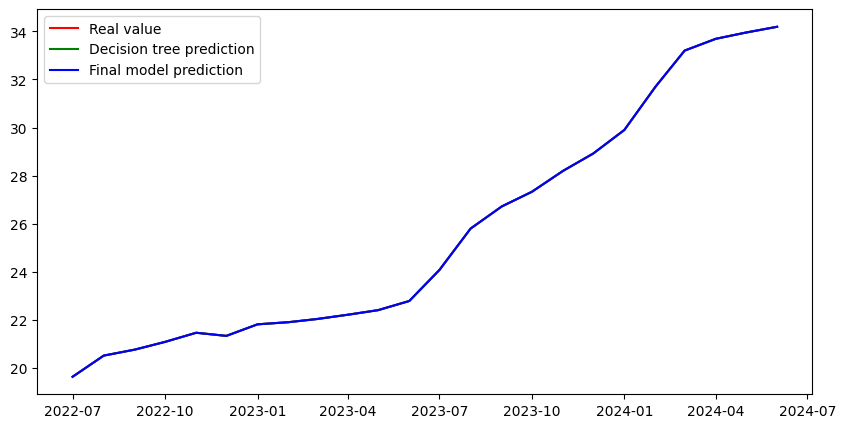

In [51]:
pred1 = GS_t.predict(x_test)
pred2 = model.predict(x_test)
n_y = y_test

plt.figure(figsize=(10, 5))

plt.plot(n_y.index, n_y, label="Real value", c="r")
plt.plot(n_y.index, pred1, label="Decision tree prediction", c="g")
plt.plot(n_y.index, pred2, label="Final model prediction", c="b")

plt.legend()
plt.show()

<div>
    <p>
        The final model and best decision_tree model predict infaltion rate perfectly. As seen above,there is a perfect overlap of values
    </p>
</div>

### Forecast analysis using Final model

Taking a random sample from the dataset, reduce or increase by weights and predict using model to see how it performs 

In [57]:
def generateWeights(decrease=True):
    weights = []
    while True:
        val = np.random.random_sample()
        if decrease:
            # initialize weights that decrease values 
            if val >= 0.9:
                weights.append(val)
                
        else:
            # initialize weights that increase values
            if val <= 0.1:
                weights.append(val + 1)
                
        if len(weights) == len(features):
            break
        
    return np.array(weights)

weights = generateWeights(decrease=False)    

In [54]:
# This samples the dataset by selecting a single row of data, adjusts the values and makes prediction. 
def randomExperiments(n_experiments, weights, model, future_steps=12):
    """Performs random experiments on inflation dataset and shows a visual representation of experiments<br>
    <b><strong>n_experiment:</strong></b> Number of experiments to perform <br>
    <b><strong>weights:</strong></b> Weights values used to produce forecast<br>
    <b><strong>Model:</strong></b> Model to perform experiment on<br>
    <b><strong>Future_steps:</strong></b> Number of timesteps into the future to predict (defualt= 12 (1 year))<br>
    <b><strong>Returns:</strong></b> Forecast values (num_experiments, num_future_steps), Forecast result (num_experiment, num_future_steps)
    """
    n_cols = np.floor_divide(n_experiments, 2)
    fig, ax = plt.subplots(2, n_cols, figsize=(20, 10))
    X_future = []
    future_preds = []
    for exp in range(n_experiments):
        sample = inflation.sample(1)[features].copy()
        future_predictions = []
        future = []
        future_dates = pd.date_range(sample.index[0], periods=future_steps, freq="M")
        row = np.floor_divide(exp, n_cols)
        col = exp % n_cols
        for _ in range(future_steps):
            future_pred = model.predict(sample)
            future_predictions.append(future_pred)
            sample *= weights
            future.append(sample.to_dict(orient="tight", index=False)["data"][0])
        X_future.append(future)
        future_preds.append(future_predictions)
        ax[row][col].plot(future_dates, future_predictions, color="r", linestyle="solid")
        ax[row][col].set_title(f"Forecase from expiriment {exp}")
        ax[row][col].set_xlabel("Date")
        ax[row][col].set_ylabel("Inflation rate")
        ax[row][col].grid(True)
    
    return X_future, future_preds
    
    



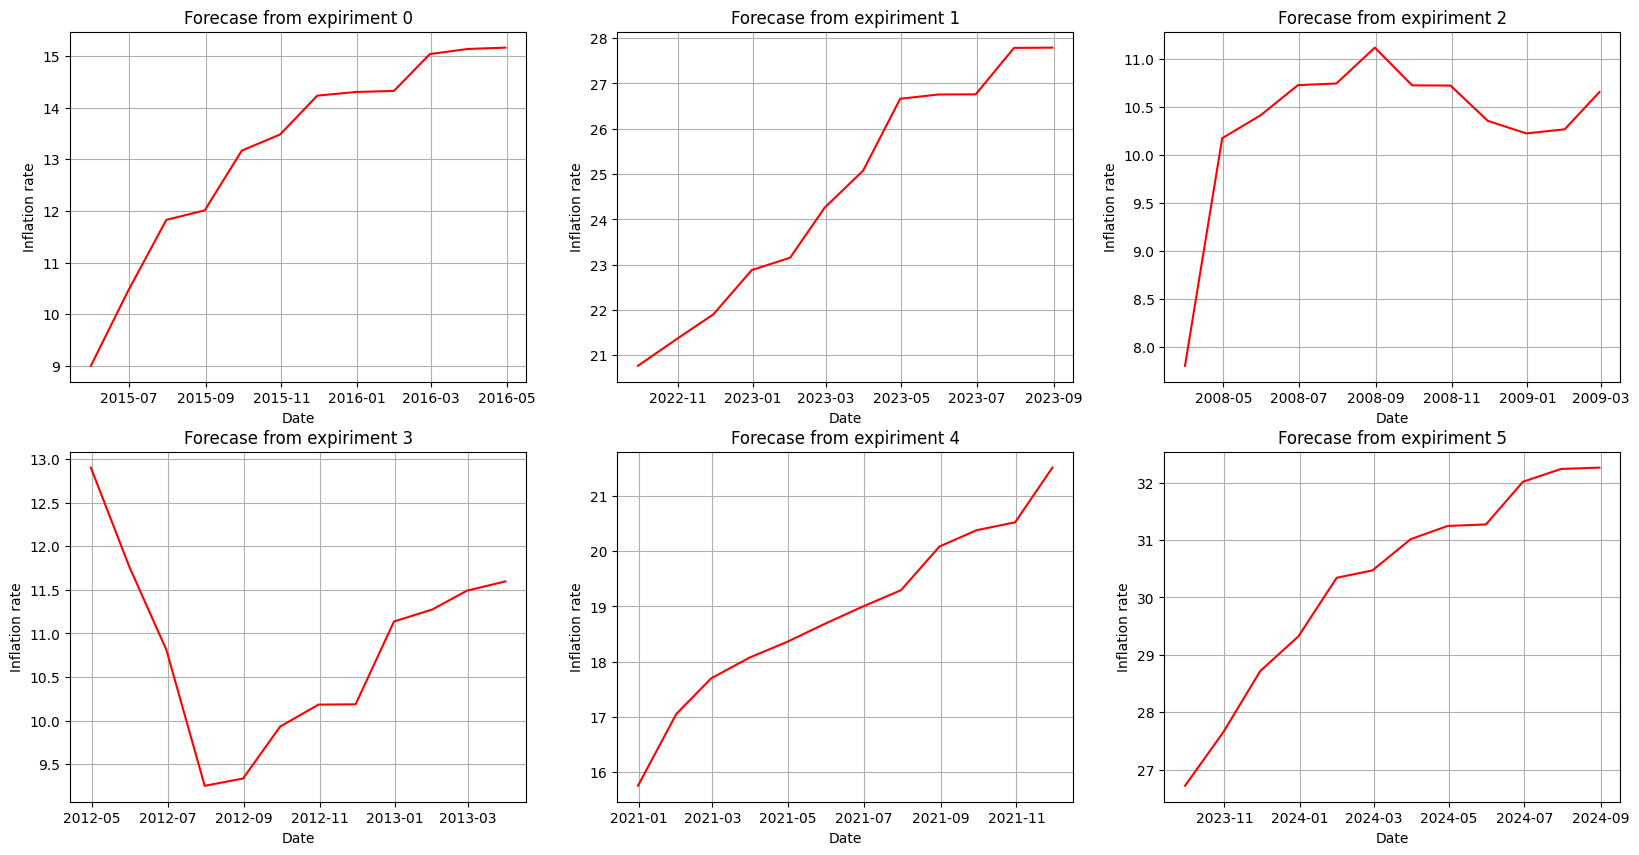

In [160]:

data, forecaste = randomExperiments(6, weights, model)

In [161]:
pd.DataFrame(data[5], columns=features)

,CPI_Food,CPI_Health,CPI_Transport,Buying_rate,Selling_rate,CPI_Food_MA_3,CPI_Food_MA_6,CPI_Health_MA_3,CPI_Transport_MA_3,Buying_rate_MA_3,Buying_rate_MA_6,Selling_rate_MA_3,Selling_rate_MA_6
0,772.429547,454.430456,537.615814,775.902343,794.591834,781.727177,720.747256,448.852375,530.932945,846.731611,696.584555,799.914679,675.661310
1,809.219418,457.814687,547.090757,791.276232,828.765655,852.759879,757.684250,454.935837,543.364091,924.559074,744.578976,824.082631,699.447756
2,847.761547,461.224120,556.732687,806.954742,864.409223,930.247064,796.514197,461.101750,556.086297,1009.540060,795.880194,848.980773,724.071597
3,888.139389,464.658944,566.544546,822.943909,901.585751,1014.775228,837.334110,467.351233,569.106379,1102.332086,850.716049,874.631167,749.562312
4,930.440378,468.119349,576.529330,839.249888,940.361168,1106.984158,880.245969,473.685417,582.431309,1203.653105,909.330073,901.056540,775.950420
5,974.756112,471.605523,586.690085,855.878958,980.804238,1207.571778,925.356984,480.105450,596.068227,1314.287060,971.982582,928.280308,803.267513
6,1021.182550,475.117660,597.029913,872.837519,1022.986685,1317.299429,972.779856,486.612496,610.024436,1435.089952,1038.951827,956.326591,831.546296
7,1069.820222,478.655952,607.551971,890.132101,1066.983315,1436.997632,1022.633065,493.207735,624.307413,1566.996460,1110.535227,985.220241,860.820625
8,1120.774447,482.220594,618.259469,907.769362,1112.872153,1567.572375,1075.041161,499.892362,638.924809,1711.027174,1187.050698,1014.986860,891.125547
9,1174.155558,485.811783,629.155677,925.756090,1160.734579,1710.011970,1130.135077,506.667588,653.884453,1868.296493,1268.838057,1045.652823,922.497345


<p>
After performing a number of experiments, I observed that using models like the decision tree and Gradient boost do not allow for extrapolation.This is due to their architecture, it does not allow these models to capture the trend of a data rather complex patterns. 
Therefore, this model cannot forecast but can be used to analyse the effect each feature would have on the inflation rate during planning. 
</p>

## Creating a model that can capture trends and noise

<div>
    <p>
        Inflation is a complex data time series data, it has 2 important features namely trend and noise.<br> The trend shows long-term movement of the price of goods and services, it is the underlying direction of inflation. However, noise refers to short term deviation from trend 
    </p>
</div>

### Splitting prediction between a trend and a noise model to capture complex relations 

Training model to capture the overall trend of the data

In [62]:
from sklearn.linear_model import BayesianRidge

# To capture trends, a linear model regression is used.

base_bayelsian = BayesianRidge()
param = {
    "max_iter": [300, 400, 500],
    "tol": [1e-6, 1e-7],
    "alpha_1": [1e-3, 1e-4, 1e-5, 1e-6],
    "alpha_2":[1e-3, 1e-4, 1e-5,  1e-6], 
    "lambda_1": [1e-3, 1e-4,1e-5 ,1e-6], 
    "lambda_2": [1e-3, 1e-4, 1e-5, 1e-6]
}

GS_b = GridSearchCV(base_bayelsian, param_grid=param, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=time_split, verbose=0)

GS_b.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=BayesianRidge(),
             param_grid={'alpha_1': [0.001, 0.0001, 1e-05, 1e-06],
                         'alpha_2': [0.001, 0.0001, 1e-05, 1e-06],
                         'lambda_1': [0.001, 0.0001, 1e-05, 1e-06],
                         'lambda_2': [0.001, 0.0001, 1e-05, 1e-06],
                         'max_iter': [300, 400, 500], 'tol': [1e-06, 1e-07]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

Training noise model

In [82]:
# To capture noise, regression models such as 
pred = GS_b.best_estimator_.predict(X)
residual = Y - pred
pred

base_model_boost = GradientBoostingRegressor()

params = {
    "loss": ["squared_error", "absolute_error"],
    "learning_rate": [1e-2, 0.1],
    "n_estimators": [150, 200], 
    "criterion": ["friedman_mse", "squared_error"], 
    "max_depth": [None, 10]
}

GS_noise = GridSearchCV(base_model_boost, param_grid=params, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=time_split, verbose=0)

GS_noise.fit(residual.to_numpy().reshape(-1,1), Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.01, 0.1],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 10], 'n_estimators': [150, 200]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

Combining the output 

In [85]:
trend_model = BayesianRidge(**GS_b.best_params_).fit(X, Y) # Model the captures trend
residuals = (Y - trend_model.predict(X)).to_numpy().reshape(-1, 1)
noise_model = GradientBoostingRegressor(**GS_noise.best_params_).fit(residuals, Y) # Model that captures noise

In [87]:
# Instead of simply adding the prediction trend and noise, I am using a linear model to generate 
# weights that would be used to combine the trend and noise

trend_pred = trend_model.predict(X)
noise_pred = noise_model.predict(residuals)

combined_features = np.vstack((trend_pred, noise_pred)).T

combiner = Lasso()
param = {
    "alpha": [1.0, 2, 3],
    "max_iter": [1000, 2000, 3000], 
    "tol": [1e-6, 1e-7]
}
GS_combiner = GridSearchCV(combiner, param_grid=param, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=5, verbose=0)

GS_combiner.fit(combined_features, Y)

combiner_model = GS_combiner.best_estimator_

In [102]:
class CombinerHelperModel:
    def __init__(self, trendModel, noiseModel, combiner, newCombiner=False):
        """<div>
        <p><b>TrendModel:</b> Model that captures trend in inflation data</p>
        <p><b>NoiseModel:</b> Model that captures noise in inflation data</p>
        <p><b>CombinerModel:</b> Model that has combined trend and noise </p>
        </div>"""
        self.trendModel = trendModel
        self.noiseModel = noiseModel
        self.combiner = combiner
        self.newCombiner = newCombiner

    def predict(self, testSet):
        trend = self.trendModel.predict(testSet)
        noise = self.noiseModel.predict(testSet) if self.newCombiner else self.noiseModel.predict(trend.reshape(-1, 1)) 
        combined = np.vstack((trend, noise)).T

        prediction = self.combiner.predict(combined)
        
        return prediction

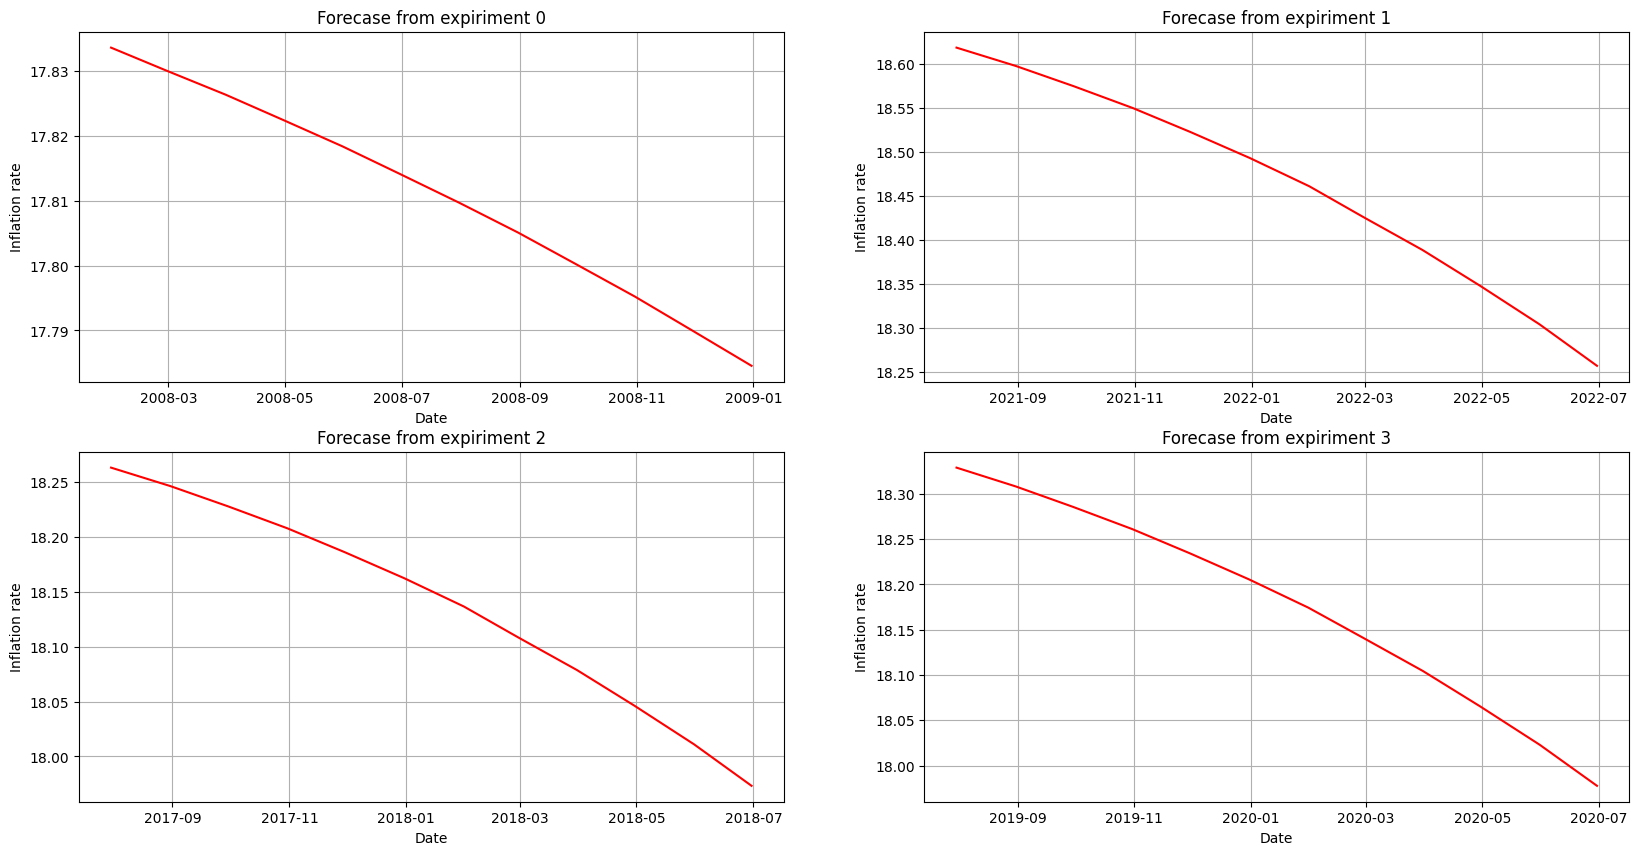

In [107]:
helper = CombinerHelperModel(trendModel=trend_model, noiseModel=noise_model, combiner=combiner_model)

# weights to reduce values
decre_weights = generateWeights(decrease=False)
data, forecast = randomExperiments(4, decre_weights, helper)

In [104]:
r2_score(y_test, helper.predict(x_test))

-1.4405632346606647

<div>
    <p>This new model performs poorly</p>
<div>

### A new combiner model

<p>Instead of using a noise model trained on residuals, I would use the Final model which is good at predicting complex patterns and combine it with a trend model</p>

In [95]:
# In 
trend_pred = trend_model.predict(X)
noise_pred = model.predict(X)

combined_features = np.vstack((trend_pred, noise_pred)).T

combiner = Lasso()
param = {
    "alpha": [1.0, 2, 3],
    "max_iter": [1000, 2000, 3000], 
    "tol": [1e-6, 1e-7]
}
GS_combiner = GridSearchCV(combiner, param_grid=param, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=5, verbose=0)

GS_combiner.fit(combined_features, Y)

new_combiner_model = GS_combiner.best_estimator_

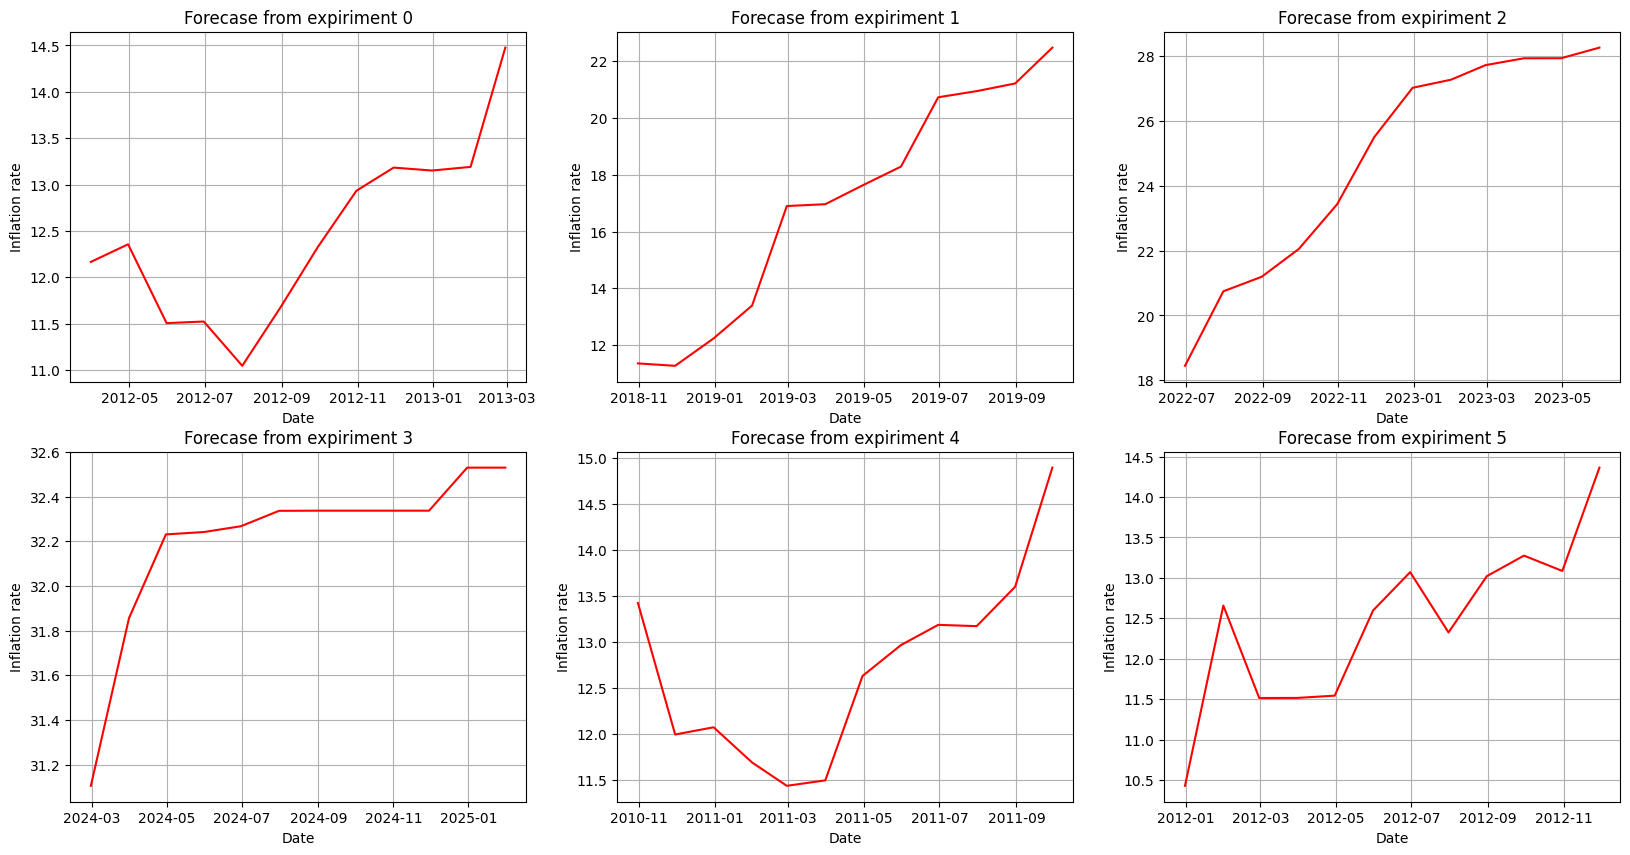

In [114]:
new_helper = CombinerHelperModel(trend_model, model, new_combiner_model, newCombiner=True)

# weights to increase values
incre_weights = generateWeights(decrease=False)
data, forecast = randomExperiments(6, incre_weights, new_helper)

In [109]:
r2_score(y_test, new_helper.predict(x_test))

0.9922671252225295

<p>High R2-score, new combiner model performs well</p>
<p>Model is still unable to extrapolate</p>

In [139]:
forecast_experiment_data =pd.DataFrame(data[3], columns=features)
forecast_experiment_data

,CPI_Food,CPI_Health,CPI_Transport,Buying_rate,Selling_rate,CPI_Food_MA_3,CPI_Food_MA_6,CPI_Health_MA_3,CPI_Transport_MA_3,Buying_rate_MA_3,Buying_rate_MA_6,Selling_rate_MA_3,Selling_rate_MA_6
0,144.014539,133.381949,139.721629,157.851942,162.485004,148.491579,141.764370,133.663309,139.756257,169.058840,165.474402,160.535183,161.293008
1,150.873775,134.375269,142.184083,160.979653,169.473162,161.984469,149.029537,135.474897,143.028479,184.597909,176.875527,165.385458,166.971278
2,158.059708,135.375988,144.689936,164.169336,176.761867,176.703407,156.667032,137.311038,146.377317,201.565253,189.062186,170.382276,172.849450
3,165.587898,136.384159,147.239952,167.422221,184.364045,192.759803,164.695934,139.172065,149.804563,220.092154,202.088502,175.530063,178.934561
4,173.474646,137.399838,149.834910,170.739560,192.293177,210.275184,173.136303,141.058316,153.312053,240.321957,216.012326,180.833381,185.233897
5,181.737031,138.423081,152.475601,174.122628,200.563325,229.382125,182.009225,142.970131,156.901668,262.411186,230.895496,186.296930,191.754999
6,190.392942,139.453944,155.162831,177.572730,209.189157,250.225243,191.336869,144.907858,160.575329,286.530749,246.804111,191.925549,198.505674
7,199.461125,140.492484,157.897422,181.091192,218.185968,272.962300,201.142537,146.871848,164.335004,312.867266,263.808824,197.724227,205.494004
8,208.961213,141.538758,160.680206,184.679371,227.569714,297.765390,211.450729,148.862456,168.182707,341.624508,281.985155,203.698101,212.728357
9,218.913780,142.592825,163.512035,188.338646,237.357036,324.822247,222.287196,150.880044,172.120500,373.024975,301.413830,209.852465,220.217392


In [140]:
pd.DataFrame(forecast[3])

,0
0,31.104709
1,31.855596
2,32.230572
3,32.241309
4,32.267214
5,32.336237
6,32.336843
7,32.336843
8,32.336843
9,32.336843


In [150]:
Y.tail(10)

Date
2023-09-01    26.72
2023-10-01    27.33
2023-11-01    28.20
2023-12-01    28.92
2024-01-01    29.90
2024-02-01    31.70
2024-03-01    33.20
2024-04-01    33.69
2024-05-01    33.95
2024-06-01    34.19
Name: Inflation_Rate, dtype: float64

In [158]:
# Comparing forecase and true inflation features 

true_features = inflation[inflation["Inflation_Rate"] == 31.7][features]

# Selecting the features at position 4 because the inflation rate is similar to 11.4 above
forecast_features = forecast_experiment_data.iloc[3]

# Determining the ratio between true and forecast
forecast_features / true_features.iloc[0] # By how much are the forecaste features more than the true features

CPI_Food              0.195535
CPI_Health            0.275610
CPI_Transport         0.258300
Buying_rate           0.110888
Selling_rate          0.122028
CPI_Food_MA_3         0.235714
CPI_Food_MA_6         0.209732
CPI_Health_MA_3       0.286995
CPI_Transport_MA_3    0.267030
Buying_rate_MA_3      0.198491
Buying_rate_MA_6      0.212202
Selling_rate_MA_3     0.158160
Selling_rate_MA_6     0.187693
dtype: float64